In [354]:
import torch
import torch.nn as nn
import torchvision
import cv2
import numpy as np
import torch.nn.functional as F
import pytorch_lightning as pl
import pathlib
import functools
import copy
import numpy.random
import open3d as o3d
import matplotlib.pyplot as plt
import pyt

from icecream import ic
from torch.utils.data import Dataset
from glob import glob
from typing import Sequence, Dict, List, Tuple, Callable, Any

ModuleNotFoundError: No module named 'pyt'

In [353]:
!pip install pytorch-lightning

     |████████████████████████████████| 527 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 134 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 398 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 952 kB 11.9 MB/s eta 0:00:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 52.0.0.post20210125
    Uninstalling setuptools-52.0.0.post20210125:
      Successfully uninstalled setuptools-52.0.0.post20210125
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.9.0
    Uninstalling fsspec-0.9.0:
      Successfully uninstalled fsspec-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


In [ ]:
!pip install numpy --upgrade

In [ ]:
import sys

sys.path.append('/opt/pvnet/')

In [ ]:
from lib.csrc.ransac_voting.ransac_voting_gpu import ransac_voting_layer_v3, estimate_voting_distribution_with_mean

In [ ]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.up(x)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UnetKeypointEncoder(nn.Module):

    def __init__(self, 
                 n_keypoints: int, 
                 n_channels: int = 3,
                 architecture: Sequence[int] = (64, 128, 256), 
                 **kwargs
    ):
        super().__init__(**kwargs)
        self.n_channels = n_channels
        self.n_keypoints = n_keypoints
        self._input_layer = DoubleConv(n_channels, architecture[0])

        encoder_in_channels = list(architecture[:-1])
        encoer_out_channels = list(architecture[1:])
        self._encoder = [
            Down(i, o) 
            for i, o in zip(encoder_in_channels, encoer_out_channels)
        ]
        
        
        decoder_in_channels = list(reversed(encoer_out_channels))
        decoder_out_channels = list(reversed(encoder_in_channels))
        self._decoder = [
            Up(i, o) 
            for i, o in zip(decoder_in_channels, decoder_out_channels)
        ]
        self._output_layer = OutConv(decoder_out_channels[-1], self.n_keypoints * 2)
        
    def forward(self, image):
        activations = []
        current_embedding = self._input_layer(image)

        for layer in self._encoder:
            current_embedding = layer(current_embedding)
            activations.append(current_embedding.clone())
        
        for layer, residual_activation in zip(self._decoder, reversed(activations)):
            current_embedding += residual_activation
            current_embedding = layer(current_embedding)
        
        keypoint_map = self._output_layer(current_embedding)
        return keypoint_map.reshape(-1, self.n_keypoints, 2)

In [355]:
class PixelVotingKeypointEstimator(pl.LightningModule):

    def __init__(self, 
                 n_keypoints: int, 
                 keypoint_encoder: nn.Module,
                 keypoint_coords: np.ndarray
    ):
        self._keypoint_encoder = keypoint_encoder
    
        
    def forward(self, frame_data: Dict):
        assert 'image' in frame_data
        assert 'segmentation' in frame_data
        keypoints_map = self._keypoint_encoder(frame_data['image'])
        segmentation_mask = frame_data['segmentation']
        keypoints_2d = ransac_voting_layer_v3(
            segmentation_mask, 
            keypoints_map,
            round_hyp_num=128,
            inlier_thresh=0.99,
            max_num=100
        )
        
        return {
            **frame_data,
            'keypoints_2d': keypoints_2d
        }

    def trainig_step(self, batch, batch_idx):
        import pdb; pdb.set_trace()
        return loss
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parametersmeters(), lr=3e-4)
        return optimizer

In [32]:
Frame = Dict[str, Any]

In [79]:
NUM_CACHED_FRAMES = 2000


class PoseEstimationDataset(Dataset):
    
    def __init__(self, 
                 pvnet_dataset_root: str,
                 transforms: List[Callable[[Frame], Frame]] = tuple(),
                 **kwargs):

        super().__init__(**kwargs)
        self._root = pathlib.Path(pvnet_dataset_root)
        self._transforms = transforms
        self._model = o3d.io.read_triangle_mesh(str(self._root / 'model.ply'))
        self._camera_intrinsics = np.loadtxt(str(self._root / 'camera.txt'))
        self._frame_ids = [
            pathlib.Path(f).stem
            for f in glob(str(self._root / 'rgb' / '*.jpg'))
        ]
        
    def __len__(self):
        return len(self._frame_ids)
        
    def __getitem__(self, idx):
        frame_id = self._frame_ids[idx]
        frame = self.load_frame(frame_id)
        for transform in self._transforms:
            frame = transform(frame)
        
        return frame
    
    def __repr__(self):
        return f'<PoseEstimationDataset num_frames={len(self)}>'
    
    def sample_3d_keypoints(self, model):
        return np.asarray(model.get_oriented_bounding_box().get_box_points())
    
    @functools.lru_cache(maxsize=NUM_CACHED_FRAMES)
    def load_frame(self, frame_id: str, raise_on_error=False):
        try:
            image = cv2.cvtColor(cv2.imread(str(self._root / 'rgb' / f'{frame_id}.jpg')), cv2.COLOR_BGR2RGB)
            if image is None:
                raise ValueError(f'Failed to load image for frame {frame_id}')
            
            mask = cv2.cvtColor(cv2.imread(str(self._root / 'mask' / f'{frame_id}.png')), cv2.COLOR_BGR2GRAY)
            if mask is None:
                raise ValueError(f'Failed to load mask for frame {frame_id}')
            
            pose = np.load(str(self._root / 'pose' / f'pose{frame_id}.npy'))
            tvec = pose[:3, 3]
            rvec, _ = cv2.Rodrigues(pose[:3, :3])
            
            keypoints_3d = self.sample_3d_keypoints(self._model)
            keypoint_2d = cv2.projectPoints(keypoints_3d, rvec, tvec, self._camera_intrinsics, np.zeros(5))

            return {
                'frame_id': frame_id,
                'image': image,
                'mask': mask,
                'pose': pose,
                'keypoints_3d': keypoints_3d,
                'keypoints_2d': keypoint_2d
            }
        except Exception as e:
            if raise_on_error:
                raise
            print(f'Failed to load frame {frame_id}')
            import traceback
            traceback.print_exc()
            return {
                'frame_id': frame_id,
                'error': e
            }

In [343]:
def generate_random_roi(
    image: np.ndarray, 
    center: np.ndarray, 
    min_roi_size: int = 32, 
    max_roi_size: int = 128, 
    max_aspect_ratio: float = 2.0,
    max_rel_offset: float = 0.2
) -> np.ndarray:
    
    image_w = image.shape[1]
    image_h = image.shape[0]

    angle = np.random.uniform(0, 2 * np.pi)
    size_w = np.random.uniform(min_roi_size, max_roi_size)
    aspect_ratio = np.random.uniform(1.0, max_aspect_ratio)
    if np.random.choice([True, False]):
        aspect_ratio = 1 / aspect_ratio
    
    size_h = size_w * aspect_ratio
    offset_u = np.random.uniform(-size_w * max_rel_offset, size_w * max_rel_offset)
    offset_v = np.random.uniform(-size_h * max_rel_offset, size_h * max_rel_offset)

    u = np.array([np.sin(angle), np.cos(angle)])
    v = np.array([np.cos(angle), -np.sin(angle)])
    offset = u * offset_u + v * offset_v

    return np.array([
        center + offset + u * size_w/2 + v * size_h/2,
        center + offset - u * size_w/2 + v * size_h/2,
        center + offset - u * size_w/2 - v * size_h/2,
        center + offset + u * size_w/2 - v * size_h/2
    ]).astype(np.uint32)

In [344]:
def compute_crop_transform_matrix(image: np.ndarray, crop_rect: np.ndarray, crop_final_size=128):

    full_frame_point3 = np.array([
        [0.0, 0.0],
        [0.0, crop_final_size // 2],
        [crop_final_size // 2, 0.0]
    ], dtype=np.float32)
    
    crop_point3 = np.array([
        crop_rect[2],
        crop_rect[1],
        crop_rect[3]
    ], dtype=np.float32)
    
    return cv2.getAffineTransform(
        crop_point3,
        full_frame_point3
    )

In [345]:
def erode_mask(frame: Frame, mask_erode_ksize: int = 15):
    mask = frame['mask']
    mask_erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (mask_erode_ksize, mask_erode_ksize))
    frame['mask'] = cv2.erode(mask, mask_erode_kernel)
    return frame

In [346]:
def random_roi_by_mask(
    frame: Frame, 
    final_crop_size: int = 64,
    min_roi_size: int = 80, 
    max_roi_size: int = 256,
    max_aspect_ratio: float = 2.0,
    max_rel_offset: float = 0.25,
    mask_erode_ksize: int = 11,
) -> np.ndarray:
    
    assert 'mask' in frame
    assert 'image' in frame

    image = frame['image']
    mask = frame['mask']

    sm = cv2.moments(mask)
    center = np.array([
        sm['m10'] / sm['m00'],
        sm['m01'] / sm['m00']
    ])
    
    roi_coords = generate_random_roi(
        image, 
        center, 
        min_roi_size=min_roi_size,
        max_roi_size=max_roi_size,
        max_aspect_ratio=max_aspect_ratio,
        max_rel_offset=max_rel_offset
    )
    
    transformation_matrix = compute_crop_transform_matrix(image, roi_coords)
    ic(
        transformation_matrix @ [*roi_coords[0], 1],
        transformation_matrix @ [*roi_coords[1], 1],
        transformation_matrix @ [*roi_coords[2], 1],
        transformation_matrix @ [*roi_coords[3], 1],
    )
    
    binary_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) // 255
    image_roi = cv2.warpAffine(
        image * binary_mask, 
        transformation_matrix,
        (final_crop_size, final_crop_size),
        cv2.INTER_LINEAR,
        cv2.BORDER_CONSTANT
    )
    
    return {
        **frame,
        'mask_center': center,
        'roi_coords': roi_coords,
        'roi_transformation_matrix': transformation_matrix,
        'image_roi': image_roi
    }

In [347]:
dataset = PoseEstimationDataset('/home/aemu/datasets/blank_pvnet', 
                                transforms=[
                                    erode_mask, 
                                    random_roi_by_mask
                                ])
dataset

<PoseEstimationDataset num_frames=1148>

In [351]:
sample_frame_indices = np.random.choice(range(len(dataset)), size=8, replace=False)
sample_frames = [dataset[i] for i in sample_frame_indices]
len(sample_frames)

ic| transformation_matrix @ [*roi_coords[0], 1]: array([64., 64.])
    transformation_matrix @ [*roi_coords[1], 1]: array([ 0., 64.])
    transformation_matrix @ [*roi_coords[2], 1]: array([0., 0.])
    transformation_matrix @ [*roi_coords[3], 1]: array([64.,  0.])
ic| transformation_matrix @ [*roi_coords[0], 1]: array([64., 64.])
    transformation_matrix @ [*roi_coords[1], 1]: array([-7.10542736e-15,  6.40000000e+01])
    transformation_matrix @ [*roi_coords[2], 1]: array([-1.42108547e-14,  0.00000000e+00])
    transformation_matrix @ [*roi_coords[3], 1]: array([64.,  0.])
ic| transformation_matrix @ [*roi_coords[0], 1]: array([64., 64.])
    transformation_matrix @ [*roi_coords[1], 1]: array([ 0., 64.])
    transformation_matrix @ [*roi_coords[2], 1]: array([ 0.00000000e+00, -3.55271368e-15])
    transformation_matrix @ [*roi_coords[3], 1]: array([ 6.40000000e+01, -3.55271368e-15])
ic| transformation_matrix @ [*roi_coords[0], 1]: array([64., 64.])
    transformation_matrix @ [*roi_c

8

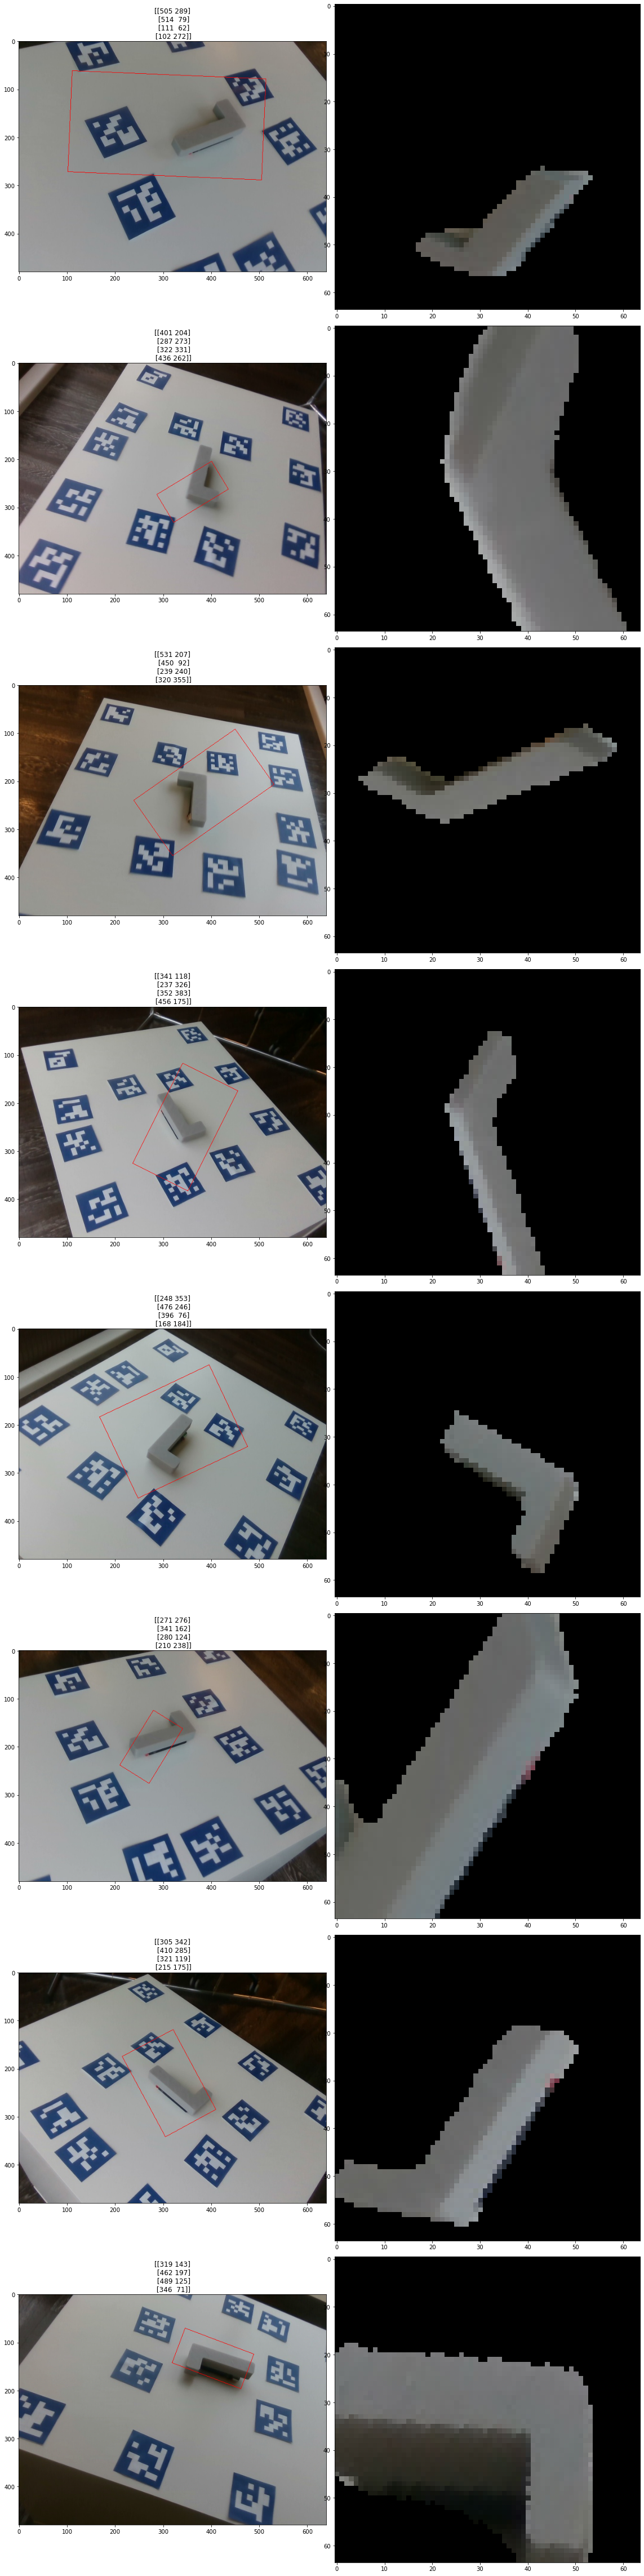

In [352]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(16, 64))
for i, row in enumerate(axes):
    full_frame = copy.deepcopy(sample_frames[i]['image'])
    roi_rect = sample_frames[i]['roi_coords']

    image_roi = copy.deepcopy(sample_frames[i]['image_roi'])
    row[0].set_title(str(roi_rect))

    cv2.line(full_frame, roi_rect[0], roi_rect[1], (255, 0, 0))
    cv2.line(full_frame, roi_rect[1], roi_rect[2], (255, 0, 0))
    cv2.line(full_frame, roi_rect[2], roi_rect[3], (255, 0, 0))
    cv2.line(full_frame, roi_rect[3], roi_rect[0], (255, 0, 0))

    row[0].imshow(full_frame)
    row[1].imshow(image_roi)
    

fig.tight_layout()

In [ ]:
trainer = pl.Trainer()
encoder = U